# Create publication plots

#### Configure matplotlib for final figure styles

In [1]:
%matplotlib inline
# Configure matplotlib
from s90_helper_functions import *
configure_matplotlib()

# Other imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import subprocess

In [2]:
# # Use window's palatino ttf file when running from WSL2
# import matplotlib.font_manager as fm
# font_path = '/mnt/c/Windows/fonts/pala.ttf'
# font_props = fm.FontProperties(fname=font_path)
# mpl.rcParams['font.serif'] = font_props.get_name()
# mpl.rcParams['font.size'] = 10                        # LaTeX default is 10pt font.
# mpl.rcParams['axes.labelsize'] = 10          
# mpl.rcParams['legend.fontsize'] = 8
# mpl.rcParams['xtick.labelsize'] = 8
# mpl.rcParams['ytick.labelsize'] = 8

#### Read data

In [2]:
resolution_data = pd.read_csv('./data/final_csv/predictions_resolution.csv')
resolution_data = resolution_data[[
    'method',
    'resolution',
    'x_bin', 
    'y_bin',
    'orientation_bin',
    'location_error',
    'orientation_error',
    'orientation_error_no_phase',
    'prediction_error'
]]
resolution_data.rename(
    columns={
        'location_error': 'location', 
        'orientation_error': 'orientation', 
        'orientation_error_no_phase': 'orientation_no_phase',
        'prediction_error': 'prediction'
    }, 
    inplace=True
)
resolution_data = pd.melt(
    resolution_data,
    id_vars=['method', 'resolution', 'x_bin', 'y_bin', 'orientation_bin'],
    value_vars=['location', 'orientation', 'orientation_no_phase', 'prediction'],
    var_name='error_type', 
    value_name='error_value'
)
resolution_data.head()

,method,resolution,x_bin,y_bin,orientation_bin,error_type,error_value
0,LCMV,0.01,-0.42,0.02,3.141593,location,0.021248
1,LCMV,0.01,0.08,0.14,3.267256,location,0.000202
2,LCMV,0.01,0.42,0.26,2.953097,location,0.246580
3,LCMV,0.01,0.36,0.48,2.827433,location,0.478388
4,LCMV,0.01,0.20,0.02,0.691150,location,0.009963


In [3]:
data_row_order = resolution_data.query('error_type == "location" & resolution == 0.01') \
                                .groupby('method') \
                                .agg({'error_value': np.median}) \
                                .sort_values('error_value') \
                                .reset_index() \
                                .method.to_list()
data_row_order

['QM', 'GN', 'MLP', 'KNN', 'ELM', 'NR', 'LCMV', 'CWT', 'RND']

In [4]:
sensor_data = pd.read_csv('./data/final_csv/predictions_input_mode.csv')
sensor_data = sensor_data[[
    'method',
    'input_mode',
    'x_bin', 
    'y_bin',
    'orientation_bin',
    'location_error',
    'orientation_error',
    'orientation_error_no_phase',
    'prediction_error'
]]
sensor_data.rename(
    columns={
        'location_error': 'location', 
        'orientation_error': 'orientation', 
        'orientation_error_no_phase': 'orientation_no_phase',
        'prediction_error': 'prediction'
    }, 
    inplace=True
)
sensor_data = pd.melt(
    sensor_data,
    id_vars=['method', 'input_mode', 'x_bin', 'y_bin', 'orientation_bin'],
    value_vars=['location', 'orientation', 'orientation_no_phase', 'prediction'],
    var_name='error_type', 
    value_name='error_value'
)
sensor_data.head()

,method,input_mode,x_bin,y_bin,orientation_bin,error_type,error_value
0,LCMV,x+y,-0.42,0.02,3.141593,location,0.029940
1,LCMV,x+y,0.08,0.14,3.267256,location,0.000202
2,LCMV,x+y,0.42,0.26,2.953097,location,0.246580
3,LCMV,x+y,0.36,0.48,2.827433,location,0.565766
4,LCMV,x+y,0.20,0.02,0.691150,location,0.009963


In [5]:
sensor_row_order = sensor_data.query('error_type == "location" & input_mode == "x+y"') \
                              .groupby('method') \
                              .agg({'error_value': np.median}) \
                              .sort_values('error_value') \
                              .reset_index() \
                              .method.to_list()
sensor_row_order

['GN', 'MLP', 'KNN', 'ELM', 'LSQ', 'NR', 'LCMV', 'CWT', 'RND']

In [6]:
def combine_data(resolution_data, sensor_data):
    res_data = resolution_data.query('resolution== ' + str(0.01) + ' & method=="QM"')
    sen_data = sensor_data.query('input_mode== \"' + "x+y" + '\"')
    res_data = res_data.drop(['resolution'], axis=1)
    sen_data = sen_data.drop(['input_mode'], axis=1)
    combined_data = pd.concat([res_data, sen_data], ignore_index=True)
    return(combined_data)

combined_data = combine_data(resolution_data, sensor_data)
combined_data.head()

,method,x_bin,y_bin,orientation_bin,error_type,error_value
0,QM,-0.42,0.02,3.141593,location,0.018777
1,QM,0.08,0.14,3.267256,location,0.000203
2,QM,0.42,0.26,2.953097,location,0.065142
3,QM,0.36,0.48,2.827433,location,0.143805
4,QM,0.20,0.02,0.691150,location,0.000165


In [7]:
combined_row_order = combined_data.query('error_type == "location"') \
                                .groupby('method') \
                                .agg({'error_value': np.median}) \
                                .sort_values('error_value') \
                                .reset_index() \
                                .method.to_list()
combined_row_order

['QM', 'GN', 'MLP', 'KNN', 'ELM', 'LSQ', 'NR', 'LCMV', 'CWT', 'RND']

#### Spatial error projections

In [8]:
def draw_spatial_contours(data, **kwargs):
    if data.error_type.nunique() > 1:
        raise ValueError('Plot one eror type at a time!')
    
    levels = np.r_[0, 0.01, 0.03, 0.05, 0.09]
    if data.error_type.iloc[1] == 'location':
        cmap='Blues_r'
        label=r'$E$\boldmath{$_p$} (\si{m})'
        tick_labels = levels
    elif data.error_type.iloc[1] == 'orientation':
        cmap='Oranges_r'
        label=r'$E_{\varphi}$ (\(\times\pi\) \si{rad})'        
        tick_labels = levels    
    elif data.error_type.iloc[1] == 'orientation_no_phase':
        cmap='Purples_r'
        label=r"$E_{\varphi}'$ (\(\times\pi\) \si{rad})"        
        tick_labels = levels
    else:
        cmap='Greens_r'
        label=r'$E_{norm}$'        
        tick_labels = levels
    
    g = sns.FacetGrid(data, height=1, **kwargs)
    g = g.map_dataframe(
        plot_spatial_heatmap, 
        'x_bin', 'y_bin', 'error_value', 
        levels,
        cmap=cmap
    )
    g = g.set_axis_labels(r'\(x\) (\si{m})', '\(y\) (\si{m})')
    
    g.fig.subplots_adjust(
        left=0.075,
        right=0.88,
    )
    num_rows = g.axes.shape[0]
    for idx in range(num_rows):
        ax_pos = g.axes[idx][3].get_position()
        height = ax_pos.y1 - ax_pos.y0 +0.03
        rect = [0.9, ax_pos.y0-0.02, 0.015, height]
        cbar_ax = g.fig.add_axes(rect)
        c = plt.colorbar(cax=cbar_ax, spacing='proportional')
        c.set_ticks(levels[1:])
        c.set_ticklabels(tick_labels[1:])
        c.set_label(label)
    g.fig.set_figwidth(6)
#     g.fig.set_figheight(9)
    return g

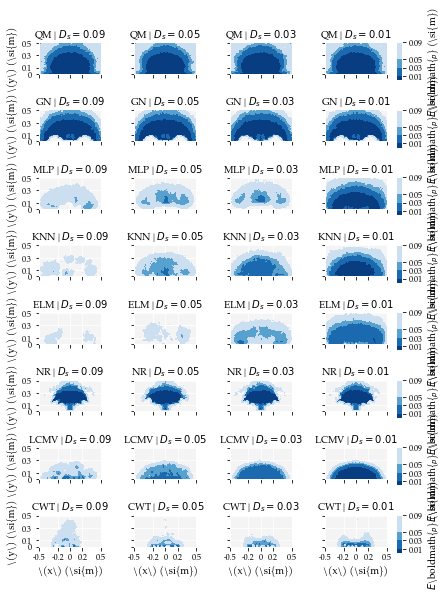

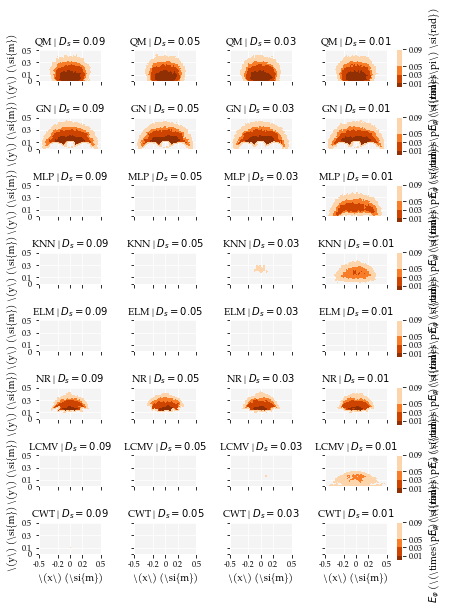

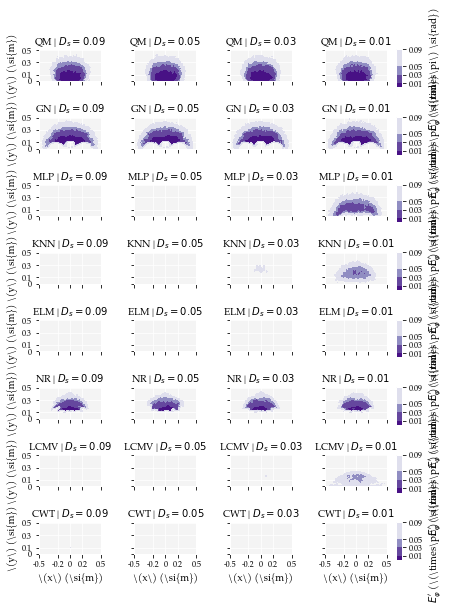

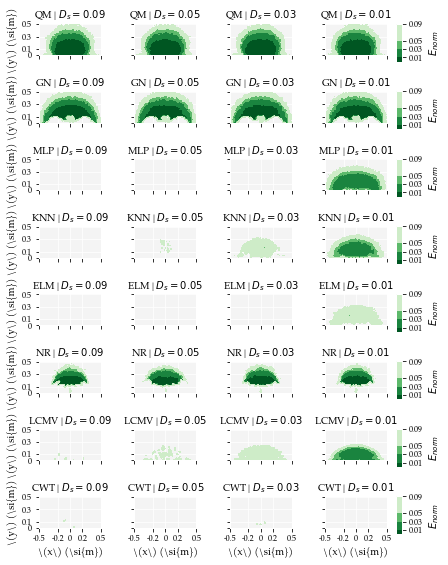

In [9]:
for etype in resolution_data.error_type.unique():
    # location error data
    g = draw_spatial_contours(
        resolution_data.query('error_type == "' + etype + '"'),
        col='resolution', row='method',
        col_order=np.flip(resolution_data.resolution.unique()),
        row_order=data_row_order[:-1]
    )
    g = g.set_titles(r'{row_name} | $D_s={col_name}$')
    g.fig.savefig('images/publication/resolution_spatial_' + etype)

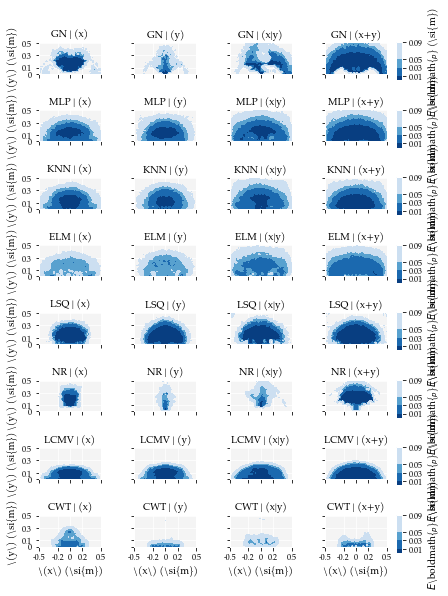

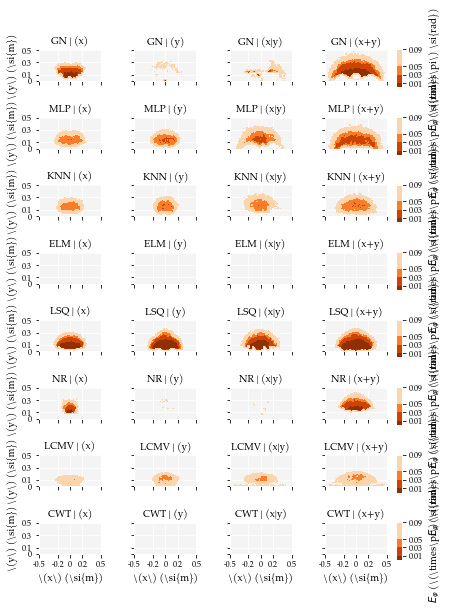

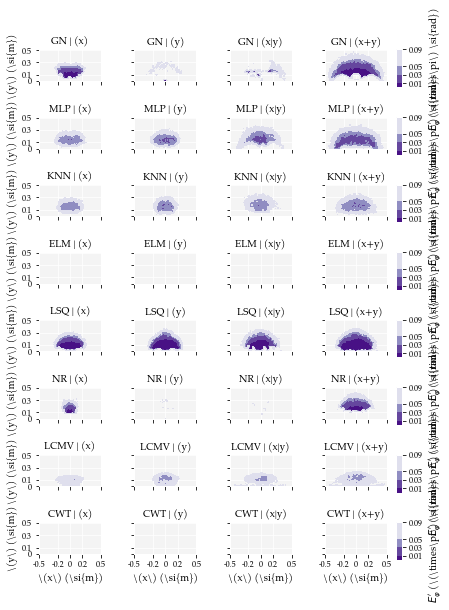

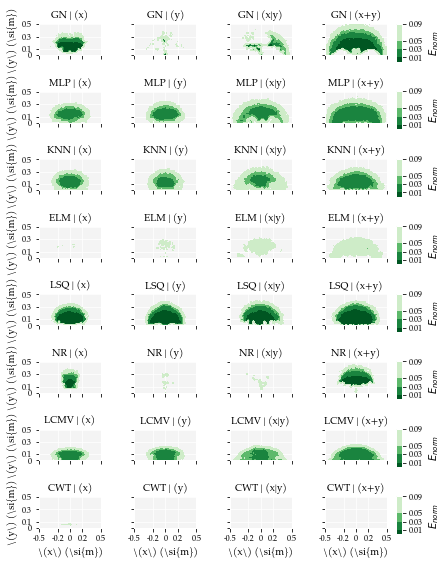

In [10]:
for etype in sensor_data.error_type.unique():
    # location error data
    g = draw_spatial_contours(
        sensor_data.query('error_type == "' + etype + '"'),
        col='input_mode', row='method',
        col_order=['x', 'y', 'x|y', 'x+y'],
        row_order=sensor_row_order[:-1]
    )
    g = g.set_titles(r'{row_name} | ({col_name})')
    g.fig.savefig('images/publication/sensors_spatial_' + etype)

#### Polar error projections

In [11]:
def draw_orientation_contours(data, **kwargs):
    if data.error_type.nunique() > 1:
        raise ValueError('Plot one eror type at a time!')
    
    levels = np.r_[0, 0.01, 0.03, 0.05, 0.09]
    if data.error_type.iloc[0] == 'location':
        cmap='Blues_r'
        label=r'$E$\boldmath{$_p$} (\si{m})'
        tick_labels = levels
    elif data.error_type.iloc[0] == 'orientation':
        cmap='Oranges_r'
        label=r'$E_{\varphi}$ (\(\times\pi\) \si{rad})'        
        tick_labels = levels
    elif data.error_type.iloc[0] == 'orientation_no_phase':
        cmap='Purples_r'
        label=r"$E_{\varphi}'$ (\(\times\pi\) \si{rad})"        
        tick_labels = levels
    else:
        cmap='Greens_r'
        label=r'$E_{norm}'        
        tick_labels = levels
    
    g = sns.FacetGrid(
        data, 
        subplot_kws=dict(projection='polar'), 
        height=1, aspect=1.5, 
        despine=False, 
        sharex=False, sharey=False,
        **kwargs
    )
    g = g.map_dataframe(
        plot_orienation_heatmap, 
        'orientation_bin', 'y_bin', 'error_value',
        levels, 
        cmap=cmap,
        yticks=[0.2, 0.4],
        yticklabels=['0.2', ''],
        labels=False
    )
    g = g.set_axis_labels(r'', r'')
    g.fig.subplots_adjust(
        hspace=0.75, 
        wspace=0,
        bottom=.01, 
        left=0.02, 
        top=.96, 
        right=.91
    )
    fig = fix_polar_grid(g.fig, is_grid=True)
    num_rows = g.axes.shape[0]
    for idx in range(num_rows):
        ax_pos = g.axes[idx][3].get_position()
        height = ax_pos.y1 - ax_pos.y0
        rect = [0.9, ax_pos.y0, 0.014, height]
        cbar_ax = g.fig.add_axes(rect)
        c = plt.colorbar(cax=cbar_ax, spacing='proportional')
        c.set_ticks(levels[1:])
        c.set_ticklabels(tick_labels[1:])
        c.set_label(label)

    g.fig.set_figwidth(6)
    g.fig.set_figheight(8)

    return g, fig

/home/jelmer/miniconda3/envs/basic_jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jelmer/miniconda3/envs/basic_jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jelmer/miniconda3/envs/basic_jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jelmer/miniconda3/envs/basic_jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


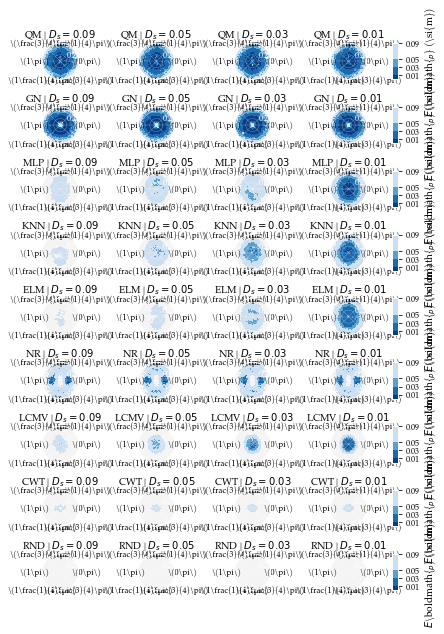

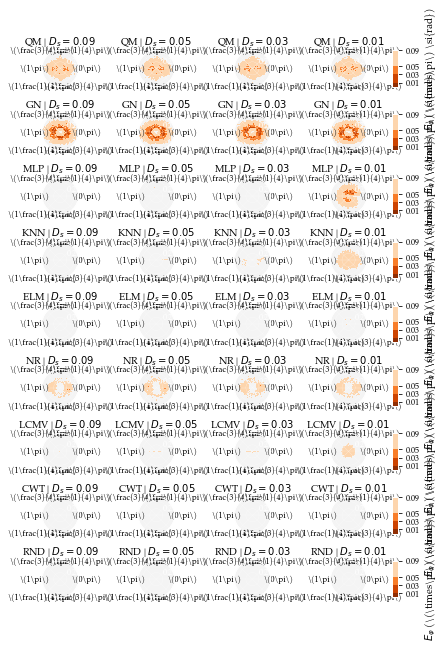

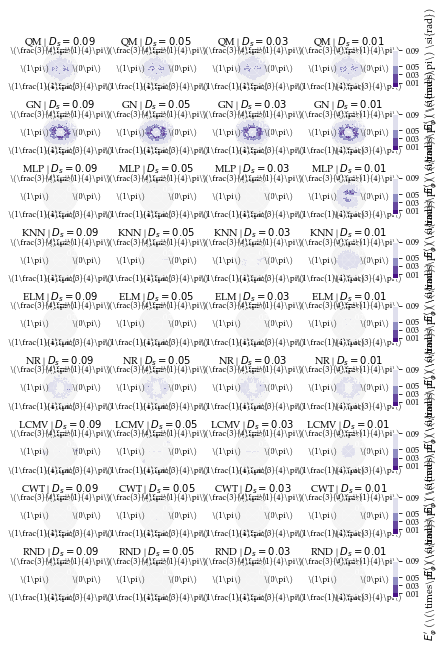

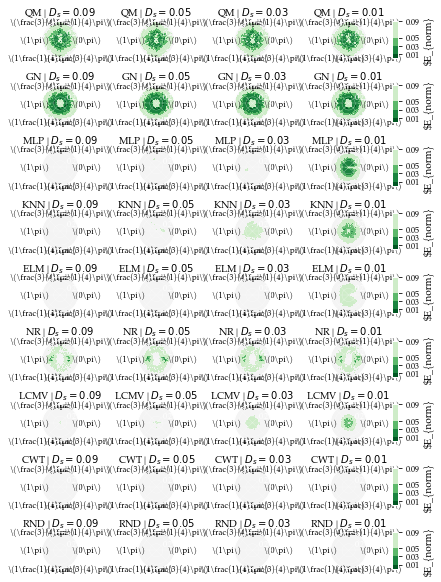

In [12]:
for etype in resolution_data.error_type.unique():
    g, fig = draw_orientation_contours(
        resolution_data.query('error_type == "' + etype + '"'), 
        col='resolution', row='method',
        col_order=np.flip(resolution_data.resolution.unique()),
        row_order=data_row_order
    )
    g = g.set_titles(r'{row_name} | $D_s={col_name}$')
    g.fig.savefig('images/publication/resolution_polar_' + etype)

/home/jelmer/miniconda3/envs/basic_jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jelmer/miniconda3/envs/basic_jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jelmer/miniconda3/envs/basic_jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jelmer/miniconda3/envs/basic_jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


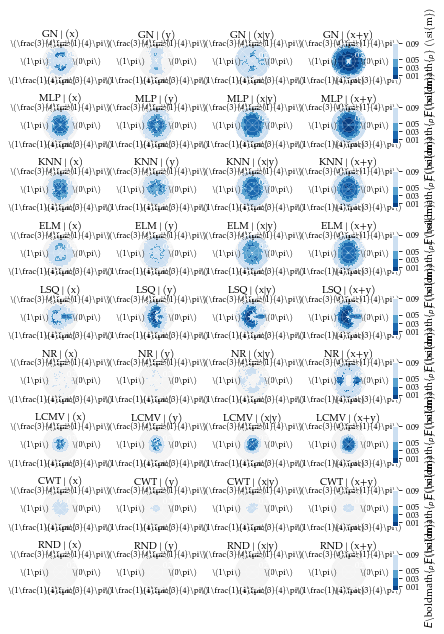

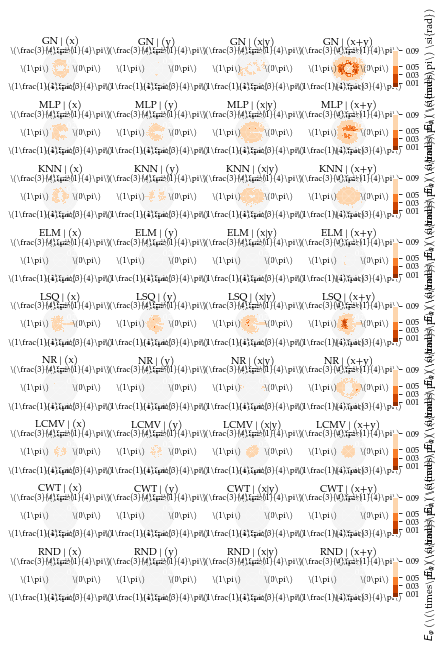

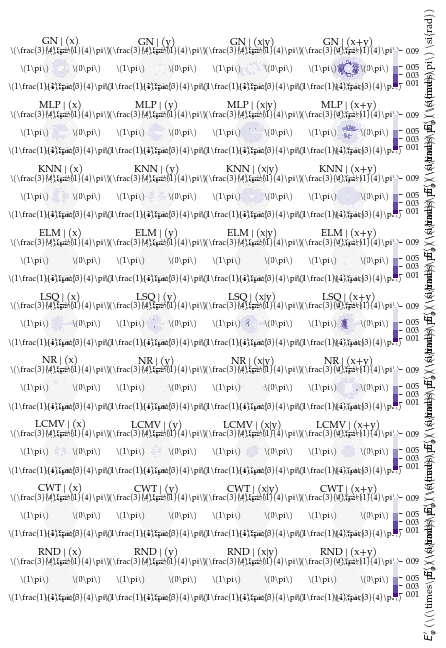

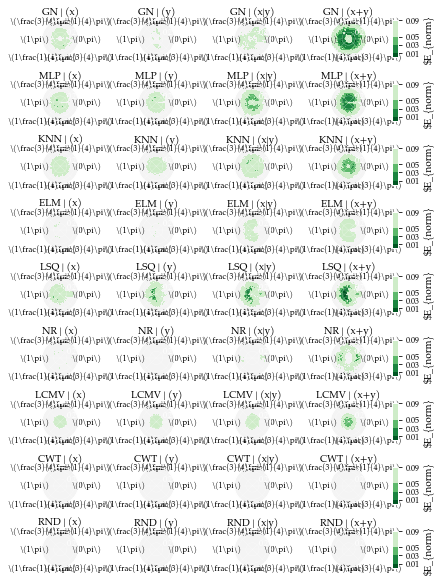

In [13]:
for etype in sensor_data.error_type.unique():
    # Location error sensors
    g, fig = draw_orientation_contours(
        sensor_data.query('error_type == "' + etype + '"'), 
        col='input_mode', row='method',
        col_order=['x', 'y', 'x|y', 'x+y'],
        row_order=sensor_row_order
    )
    g = g.set_titles(r'{row_name} | ({col_name})')
    g.fig.savefig('images/publication/sensors_polar_' + etype)

#### Area bars

In [11]:
def aggregate_area_date_base(data, exp_name, thresholds):
    if data.error_type.nunique() > 1:
        raise ValueError('Aggregate one eror type at a time!')
    
    # Hardcoded!
    cell_size = 0.02
    cell_area = cell_size * cell_size
    
    # Aggregate data to area with median error lower than each threshold
    median_errors = data.groupby(['method', exp_name, 'x_bin', 'y_bin'])['error_value'] \
                        .median()
    median_errors = median_errors.reset_index()

    for t in thresholds:
        median_errors[str(t)] = \
            median_errors.error_value.apply(lambda x: x < t)

    areas = median_errors.drop(['x_bin', 'y_bin', 'error_value'], axis=1) \
                         .groupby(['method', exp_name]) \
                         .sum()
    areas = areas * cell_area
    return areas

def aggregate_area_data_abs(data, exp_name, thresholds): 
    areas = aggregate_area_date_base(data, exp_name, thresholds)
    areas = areas.reset_index().melt(id_vars=['method', exp_name], var_name='threshold', value_name='area')
    areas = areas.astype({'threshold':'float64'})
    return areas

def aggregate_area_data(data, exp_name, thresholds):   
    
    areas = aggregate_area_date_base(data, exp_name, thresholds)
    areas_abs = areas.copy()

    # Subtract to get how much area is between thresholds
    for idx in range(len(thresholds)-1):
        name_up = str(thresholds[idx+1])
        name_down = str(thresholds[idx])
        areas[name_up] = areas_abs[name_up] - areas_abs[name_down]
    
    # Melt the columns into a single columns
    areas = areas.reset_index().melt(id_vars=['method', exp_name], var_name='threshold', value_name='area')
    areas = areas.astype({'threshold':'float64'})
    
    return areas

def plot_area_bars(data, exp_variable, **kwargs):
    if data.error_type.nunique() > 1:
        raise ValueError('Plot one eror type at a time!')
    
    levels = [0.01, 0.03, 0.05, 0.09]
    if data.error_type.iloc[1] == 'location':
        colors = contourColors(levels, 'Blues_r')
        stack_labels=list(reversed(["$\leq$" + "{:.2f}".format(x) + '~\si{m}' for x in np.flip(levels)]))
        legend_label=r'Med. $E_p$'
    elif data.error_type.iloc[1] == 'orientation':
        colors = contourColors(levels, 'Oranges_r')
        stack_labels=list(reversed(["$\leq$" + "{:.2f}".format(x) + '\(\pi\)~\si{rad}' for x in np.flip(levels)]))
        legend_label=r'Med. $E_\varphi$' 
    elif data.error_type.iloc[1] == 'orientation_no_phase':
        colors = contourColors(levels, 'Purples_r')
        stack_labels=list(reversed(["$\leq$" + "{:.2f}".format(x) + '\(\pi\)~\si{rad}' for x in np.flip(levels)]))
        legend_label=r"Med. $E_\varphi'$"
    else:
        colors = contourColors(levels, 'Greens_r')
        stack_labels=list(reversed(["$\leq$" + "{:.2f}".format(x) for x in np.flip(levels)]))
        legend_label=r'Med. $E_{norm}$' 

    data = aggregate_area_data(data, exp_variable, np.r_[levels, np.Inf])
    fig = plt.figure(figsize=figure_dimensions(width_ratio=1, aspect_ratio=0.55))
    groupedStackedBars(
        data, 
        'method', exp_variable, 'threshold', 'area',
        colors=colors,
        stack_labels=stack_labels,
        stack_order=levels,
        stack_title=legend_label,
        **kwargs   
    )
    plt.ylabel(r'area (\si{m\squared}) (higher is better)')
    plt.ylim([0, 0.53])
    plt.grid(axis='x')       
    return data

In [15]:
# Check waardes met de hand voor in de paper
levels = [0.01, 0.03, 0.05, 0.09]
areas = aggregate_area_data_abs(
    sensor_data.query('error_type == "orientation"'), 
    'input_mode', 
    np.r_[levels, np.Inf]
)
areas.query('threshold == 0.09 & input_mode == "x+y" & (method == "LSQ" | method == "GN")')

,method,input_mode,threshold,area
117,GN,x+y,0.09,0.2616
129,LSQ,x+y,0.09,0.1812


In [16]:
# Add LSQ to the resolution plot
lsq_data = sensor_data.query('method == "LSQ" & input_mode == "x+y"').copy()
lsq_data.drop('input_mode', inplace=True, axis=1)
lsq_data['resolution'] = 0.01
lsq_data['method'] = 'LSQ$^*$'

resolution_bars_data = resolution_data.append(lsq_data, ignore_index=True)

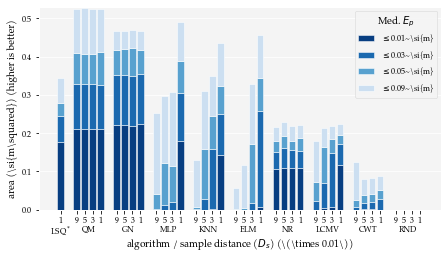

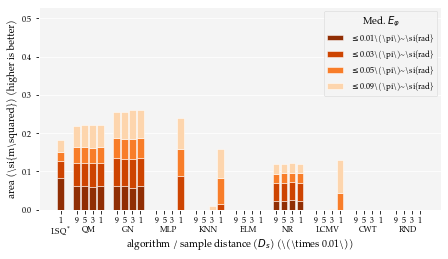

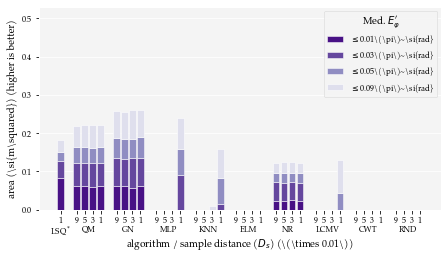

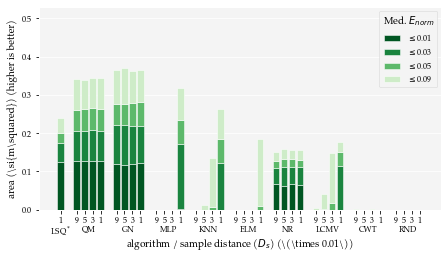

In [17]:
levels = [0.01, 0.03, 0.05, 0.09]
for etype in resolution_bars_data.error_type.unique():
    plot_area_bars(
        resolution_bars_data.query('error_type == "' + etype + '"'),
        'resolution',
        bar_order=np.flip(levels),
        bar_labels=["{:d}".format(int(x)) for x in np.flip(levels)*100],
        group_order=['LSQ$^*$'] + data_row_order,
        bar_label_rotation=0,
        group_label_offset=-20
    )
    plt.xlabel(r'algorithm / sample distance ($D_s$) (\(\times 0.01\))', labelpad=12)
    plt.gcf().subplots_adjust(
        left=0.08,
        right=0.99,
        bottom=0.155,
        top=0.99
    )
    plt.gcf().savefig('images/publication/resolution_bars_' + etype)

In [9]:
# Add LSQ to the resolution plot
qm_data = resolution_data.query('method == "QM" & resolution == 0.01').copy()
qm_data.drop('resolution', inplace=True, axis=1)
qm_data['input_mode'] = "x+y"
qm_data['method'] = 'QM$^*$'

sensors_bars_data = sensor_data.append(qm_data, ignore_index=True)

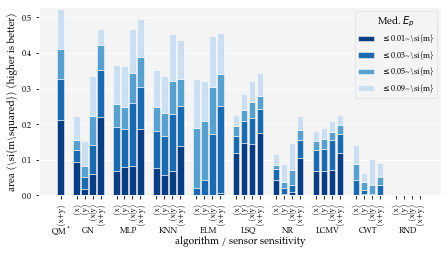

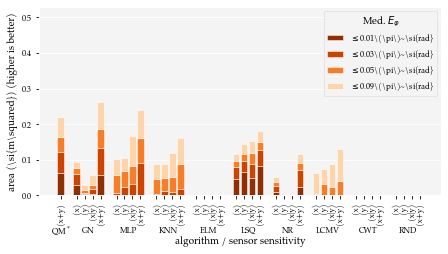

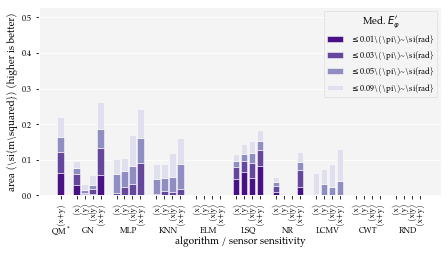

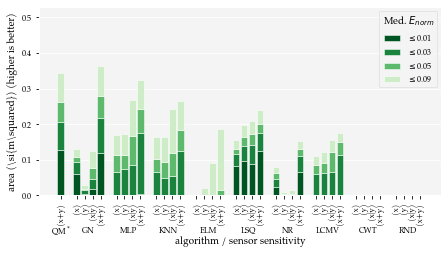

In [14]:
levels = [0.01, 0.03, 0.05, 0.09]
for etype in sensors_bars_data.error_type.unique():
    plot_area_bars(
        sensors_bars_data.query('error_type == "' + etype + '"'),
        'input_mode',
        bar_order=['x', 'y', 'x|y', 'x+y'],
        bar_labels=['(x)', '(y)', '(x|y)', '(x+y)'],
        group_order=['QM$^*$'] + sensor_row_order,
        bar_label_rotation=90,
        group_label_offset=-35
    )
    plt.xlabel(r'algorithm / sensor sensitivity', labelpad=12)
    plt.gcf().subplots_adjust(
        left=0.08,
        right=0.99,
        bottom=0.215,
        top=0.99
    )
    plt.gcf().savefig('images/publication/sensors_bars_' + etype)

#### Location and orientation errors

/home/jelmer/miniconda3/envs/basic_jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


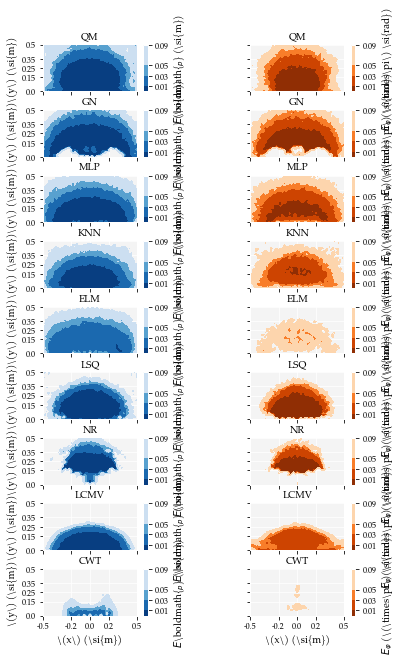

In [16]:
# Reshape for the spatial plots
def plot_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot_table(index=args[1], columns=args[0], values=args[2], aggfunc=np.median)
    color = kwargs.pop('color') # specifying a hue in the grid also forwards the label
    ticks = [0.01, 0.03, 0.05, 0.09]
    if kwargs['label'] == 'location':
        cmap='Blues_r'
        label=r'$E$\boldmath{$_p$} (\si{m})'
        tick_labels = ticks
    elif kwargs['label'] == 'orientation':
        cmap='Oranges_r'
        label=r'$E_{\varphi}$ (\(\times\pi\) \si{rad})'
        tick_labels = ticks
        d = d / np.pi
    elif kwargs['label'] == 'orientation_no_phase':
        cmap='Purples_r'
        label=r"$E_{\varphi}'$ (\(\times\pi\) \si{rad})"
        tick_labels = ticks
        d = d / np.pi
    else:
        cmap='Greens_r'
        label=r'$E_{norm}$'
        tick_labels = ticks        
        
    plt.contourf(d, levels=[0, 0.01, 0.03, 0.05, 0.09], vmin=0, vmax=0.09, cmap=cmap)
    c = plt.colorbar(spacing='proportional', aspect=10)
    c.set_ticks(ticks)
    c.set_ticklabels(tick_labels)
    c.set_label(label)
    xticks = np.array([-0.5, -0.2, 0, 0.2, 0.5])
    yticks = np.array([0, 0.15, 0.25, 0.35, 0.5])
    ax = plt.gca()
    ax.set_aspect('equal','box')
    ax.set_xticks(scale_ticks(xticks, ax.get_xlim()))
    ax.set_yticks(scale_ticks(yticks, ax.get_ylim()))
    ax.set_xticklabels(xticks, rotation=0)
    ax.set_yticklabels(yticks)

row_order = combined_row_order
g = sns.FacetGrid(combined_data, height=0.95, row='method', col='error_type', hue='error_type',
                  row_order=row_order[:-1],
                  col_order=['location', 'orientation'])
g = g.map_dataframe(plot_heatmap, 'x_bin', 'y_bin', 'error_value')
g.set_titles('{row_name}')
g.set_axis_labels(r'\(x\) (\si{m})', r'\(y\) (\si{m})')
g.fig.set_figwidth(6)
g.fig.subplots_adjust(left=0.1, bottom=0.05)

# for idx, ax in enumerate(g.axes.flat):
#     row_idx = int(np.ceil(np.maximum(0, (idx-1)) / 2))
#     if idx % 2 == 1:
#         ax.text(-0.25, 0.5,
#                 row_order[row_idx],
#                 transform=ax.transAxes,
#                 va='center',
#                 rotation=90)
#     else:
#         ax.text(-0.5, 0.5,
#                 row_order[row_idx],
#                 transform=ax.transAxes,
#                 va='center',
#                 rotation=90)

g.fig.savefig('images/publication/combined_spatial_both')

In [21]:
# Orientation plots
qm_data = resolution_data\
    .query('resolution == 0.01 & method == "QM"')\
    .drop(['resolution'], axis=1)
qm_data['method_input'] = qm_data['method'] + ' | (x+y)'
comb_data = sensor_data
comb_data['method_input'] = sensor_data['method'] + ' | (' + sensor_data['input_mode'] +')'
comb_data = comb_data.drop(['input_mode'], axis=1)
comb_data = pd.concat([comb_data, qm_data], ignore_index=True)
comb_data.head()

,method,x_bin,y_bin,orientation_bin,error_type,error_value,method_input
0,LCMV,-0.42,0.02,3.141593,location,0.029940,LCMV | (x+y)
1,LCMV,0.08,0.14,3.267256,location,0.000202,LCMV | (x+y)
2,LCMV,0.42,0.26,2.953097,location,0.246580,LCMV | (x+y)
3,LCMV,0.36,0.48,2.827433,location,0.565766,LCMV | (x+y)
4,LCMV,0.20,0.02,0.691150,location,0.009963,LCMV | (x+y)


/home/jelmer/miniconda3/envs/basic_jupyter/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


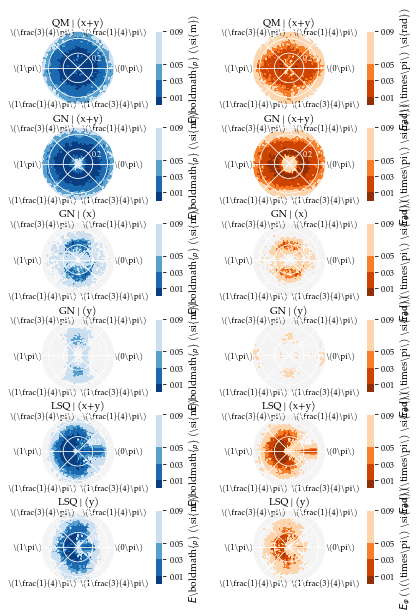

In [25]:
def plot_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot_table(index=args[1], columns=args[0], values=args[2], aggfunc=np.median)
    r = np.sort(data[args[1]].unique())[np.newaxis]
    theta = np.sort(data[args[0]].unique())[np.newaxis]
    r, theta = np.meshgrid(theta, r)
    
    color = kwargs.pop('color') # specifying a hue in the grid also forwards the label
    ticks = [0.01, 0.03, 0.05, 0.09]
    if kwargs['label'] == 'location':
        cmap='Blues_r'
        label=r'$E$\boldmath{$_p$} (\si{m})'
        tick_labels = ticks
    elif kwargs['label'] == 'orientation':
        label=r'$E_{\varphi}$ (\(\times\pi\) \si{rad})'
        d = d / np.pi
        cmap='Oranges_r'
        tick_labels = ticks
    elif kwargs['label'] == 'orientation_phase':
        label=r"$E_{\varphi}'$ (\(\times\pi\) \si{rad})"
        d = d / np.pi
        cmap='Purples_r'
        tick_labels = ticks
    else:
        label=r'$E_{norm}$'
        cmap='Greens_r'
        tick_labels = ticks
        
    plt.contourf(r, theta, d, levels=[0, 0.01, 0.03, 0.05, 0.09], vmin=0, vmax=0.09, cmap=cmap)
    c = plt.colorbar(spacing='proportional', pad=0.2, aspect=10)
    c.set_ticks(ticks)
    c.set_ticklabels(tick_labels)
    c.set_label(label)
    
    ax = plt.gca()
    ax.set_aspect('equal','box')
    ax.set_rlim([0, 0.5])
    ax.set_thetalim([0, 2*np.pi])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    rect = ax.get_position()
    ax2 = plt.gcf().add_axes(rect, polar=True)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks([0.2, 0.4])
    ax2.set_yticklabels(['0.2', ''], color='white', fontsize=mpl.rcParams['ytick.labelsize'])
    ax2.set_xticks(np.array([0, 0.25, 0.75, 1, 1.25, 1.75]) * np.pi)
    ax2.set_xticklabels([r'\(0\pi\)', r'\(\frac{1}{4}\pi\)', r'\(\frac{3}{4}\pi\)', r'\(1\pi\)', r'\(1\frac{1}{4}\pi\)', r'\(1\frac{3}{4}\pi\)'])
    ax.tick_params(axis='x', which='major', pad=-4)
    ax.tick_params(axis='both', grid_linewidth = 0.2)
#     ax2.set_xlabel(r'\(\varphi\) (\si{rad})')
#     ax2.set_ylabel(r'\(y\) (\si{m})', labelpad=15)
    ax2.set_facecolor([0, 0, 0, 0])
    


row_order = ['QM | (x+y)', 'GN | (x+y)', 'GN | (x)', 'GN | (y)', 'LSQ | (x+y)', 'LSQ | (y)']
g = sns.FacetGrid(comb_data, row='method_input', col='error_type', hue='error_type',
                  row_order=row_order,
                  col_order=['location', 'orientation'], 
                  subplot_kws=dict(projection='polar'), despine=False, sharex=False, sharey=False)
g = g.map_dataframe(plot_heatmap, 'orientation_bin', 'y_bin', 'error_value')
g.set_titles('{row_name}')
g.set_axis_labels(r'', r'')
g.fig.set_figwidth(6)
g.fig.set_figheight(8)
g.fig.subplots_adjust(hspace=0.3, wspace=0.05, left=-0.05, bottom=0.01, top=0.97)
offset = int(len(g.fig.axes) / 3)
for idx in range(0, offset):
    g.fig.axes[offset + (idx * 2) + 1] \
        .set_position(g.fig.axes[idx].get_position())

g.fig.savefig('images/publication/combined_polar_both')

#### Boxplots

In [11]:
# Check waardes met de hand voor in de paper
dat = resolution_data\
        .query('error_type == "location" & resolution == "0.09"') \
        .groupby(['method', 'resolution']) \
        .agg(
            p_05 = pd.NamedAgg(column='error_value', aggfunc=lambda g: np.percentile(g,  5)),
            p_25 = pd.NamedAgg(column='error_value', aggfunc=lambda g: np.percentile(g, 25)),
            p_50 = pd.NamedAgg(column='error_value', aggfunc=lambda g: np.percentile(g, 50)),
            p_75 = pd.NamedAgg(column='error_value', aggfunc=lambda g: np.percentile(g, 75)),
            p_95 = pd.NamedAgg(column='error_value', aggfunc=lambda g: np.percentile(g, 95)),
        )
dat

,,p_05,p_25,p_50,p_75,p_95
method,resolution,,,,,
CWT,0.09,0.028858,0.095486,0.192639,0.338111,0.532706
ELM,0.09,0.036759,0.096549,0.183291,0.347388,0.780029
GN,0.09,0.000167,0.002954,0.014709,0.058437,0.321238
KNN,0.09,0.029685,0.076018,0.129930,0.211562,0.398191
LCMV,0.09,0.022950,0.069947,0.211514,0.399761,0.559727
MLP,0.09,0.021284,0.055828,0.099099,0.174682,0.369006
NR,0.09,0.000551,0.010933,0.179650,0.805710,0.978472
QM,0.09,0.000111,0.002446,0.014500,0.047926,0.139557
RND,0.09,0.095703,0.237282,0.376040,0.547357,0.809590


In [8]:
v = 140
blue = plt.get_cmap("Blues")(v)
orange = plt.get_cmap("Oranges")(v)
green = plt.get_cmap("Greens")(v)
purple = plt.get_cmap("Purples")(v)
palette = [blue, orange, green, purple]
levels = [0.01, 0.03, 0.05, 0.09]

In [9]:
qm_data = resolution_data.query('method == "QM"').copy()
qm_data.drop('resolution', inplace=True, axis=1)
qm_data['input_mode'] = "x+y"
qm_data['method'] = 'QM$^*$'
sensors_boxplots_data = sensor_data.append(qm_data)

lsq_data = sensor_data.query('method == "LSQ"').copy()
lsq_data.drop('input_mode', inplace=True, axis=1)
lsq_data['resolution'] = 0.01
lsq_data['method'] = 'LSQ$^*$'
resolution_boxplots_data = resolution_data.append(lsq_data)

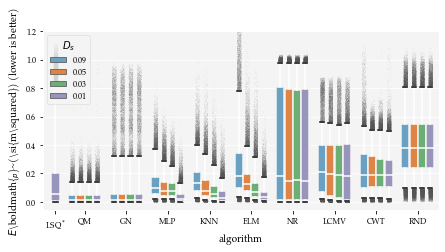

In [35]:
ax = sns.boxplot(
    data=resolution_boxplots_data.query('error_type == "location"'),
    x='method', y='error_value', hue='resolution', 
    whis=[5, 95],
    order=['LSQ$^*$'] + data_row_order,
    hue_order=np.flip(levels), 
    palette=palette,
    fliersize=0.1,
    boxprops={'edgecolor': adjust_lightness('#E5E5E5', 1.065)},
    medianprops={'color': 'white'},
    whiskerprops={'color': 'white'},
    capprops={'color': 'black'},
    flierprops={'alpha': 0.1}
)

lines = ax.get_lines()
outlier_idx = [l.get_markersize() == 0.1 for l in lines]
outliers = [l for l, i in zip(lines, outlier_idx) if i]
for outlier in outliers:
    yoffsets = outlier.get_xdata()
    outlier.set_xdata(yoffsets + np.random.uniform(-0.05, 0.05, yoffsets.size))

plt.ylim([-0.06, 1.2])
plt.legend(loc='upper left', title='$D_s$')
plt.ylabel(r'$E$\boldmath{$_p$}~(\si{m\squared}) (lower is better)')
plt.gcf().subplots_adjust(
    left=0.095,
    right=0.99,
    top=0.98,
    bottom=0.15
)
xticklabels = ax.get_xticklabels();
xticklabels[0] = mpl.text.Text(0.3, 0, 'LSQ$^*$');
plt.setp(xticklabels[0], rotation=-45)
ticks = ax.get_xticks().astype('float')
ticks[0] = 0.3
ax.set_xticks(ticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('algorithm')
plt.xlim([0, plt.xlim()[1]])
plt.gcf().set_figheight(3)
plt.gcf().savefig('images/publication/resolution_boxplots_location')
# subprocess.run(['convert', '-quality 00 -density 300x300 resolution_boxplots_location.pdf resolution_boxplots_location.png'])
# subprocess.run(["rm", 'images/publication/resolution_boxplots_location.pdf'])
plt.show()

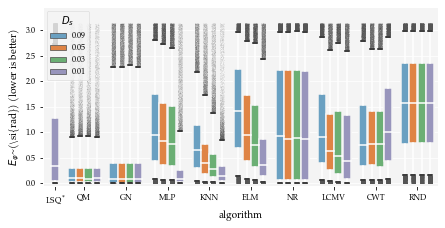

In [36]:
ax = sns.boxplot(
    data=resolution_boxplots_data.query('error_type == "orientation"'),
    x='method', y='error_value', hue='resolution', 
    whis=[5, 95],
    order=['LSQ$^*$'] + data_row_order,
    hue_order=np.flip(levels), 
    palette=palette,
    fliersize=0.1,
    boxprops={'edgecolor': adjust_lightness('#E5E5E5', 1.065)},
    medianprops={'color': 'white'},
    whiskerprops={'color': 'white'},
    capprops={'color': 'black'},
    flierprops={'alpha': 0.1}
)

lines = ax.get_lines()
outlier_idx = [l.get_markersize() == 0.1 for l in lines]
outliers = [l for l, i in zip(lines, outlier_idx) if i]
for outlier in outliers:
    yoffsets = outlier.get_xdata()
    outlier.set_xdata(yoffsets + np.random.uniform(-0.05, 0.05, yoffsets.size))
    
plt.ylim([-0.06, 1.1*np.pi])
plt.legend(loc='upper left', title='$D_s$')
plt.ylabel(r'$E_\varphi$~(\si{rad}) (lower is better)')
plt.gcf().subplots_adjust(
    left=0.095,
    right=0.99,
    top=0.98,
    bottom=0.15
)
xticklabels = ax.get_xticklabels();
xticklabels[0] = mpl.text.Text(0.3, 0, 'LSQ$^*$');
ticks = ax.get_xticks().astype('float')
ticks[0] = 0.3
ax.set_xticks(ticks)
ax.set_xticklabels(xticklabels);
ax.set_xlabel('algorithm')
plt.xlim([0, plt.xlim()[1]])
plt.gcf().set_figheight(3)
plt.gcf().savefig('images/publication/resolution_boxplots_orientation')
# subprocess.run('convert -quality 00 -density 300x300 resolution_boxplots_orientation.pdf resolution_boxplots_orientation.png')
# subprocess.run(["rm", 'images/publication/resolution_boxplots_orientation.pdf'])
plt.show()

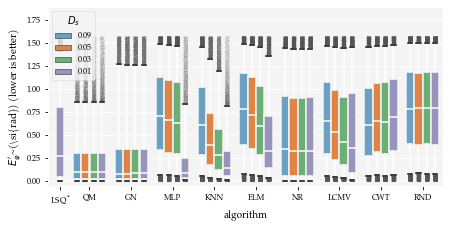

In [37]:
ax = sns.boxplot(
    data=resolution_boxplots_data.query('error_type == "orientation_no_phase"'),
    x='method', y='error_value', hue='resolution', 
    whis=[5, 95],
    order=['LSQ$^*$'] + data_row_order,
    hue_order=np.flip(levels), 
    palette=palette,
    fliersize=0.1,
    boxprops={'edgecolor': adjust_lightness('#E5E5E5', 1.065)},
    medianprops={'color': 'white'},
    whiskerprops={'color': 'white'},
    capprops={'color': 'black'},
    flierprops={'alpha': 0.1}
)

lines = ax.get_lines()
outlier_idx = [l.get_markersize() == 0.1 for l in lines]
outliers = [l for l, i in zip(lines, outlier_idx) if i]
for outlier in outliers:
    yoffsets = outlier.get_xdata()
    outlier.set_xdata(yoffsets + np.random.uniform(-0.05, 0.05, yoffsets.size))

plt.ylim([-0.06, 0.6*np.pi])
plt.legend(loc='upper left', title='$D_s$')
plt.ylabel(r"$E_\varphi'$~(\si{rad}) (lower is better)")
plt.gcf().subplots_adjust(
    left=0.095,
    right=0.99,
    top=0.98,
    bottom=0.15
)
xticklabels = ax.get_xticklabels();
xticklabels[0] = mpl.text.Text(0.3, 0, 'LSQ$^*$');
ticks = ax.get_xticks().astype('float')
ticks[0] = 0.3
ax.set_xticks(ticks)
ax.set_xticklabels(xticklabels);
ax.set_xlabel('algorithm')
plt.xlim([0, plt.xlim()[1]])
plt.gcf().set_figheight(3)
plt.gcf().savefig('images/publication/resolution_boxplots_orientation_no_phase')
# subprocess.run('convert -quality 00 -density 300x300 images/publication/resolution_boxplots_orientation_no_phase.pdf images/publication/resolution_boxplots_orientation_no_phase.png')
# subprocess.run(["rm", 'images/publication/resolution_boxplots_orientation_no_phase.pdf'])
plt.show()

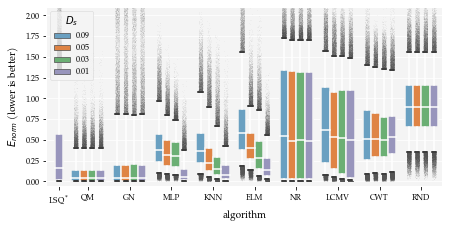

In [38]:
ax = sns.boxplot(
    data=resolution_boxplots_data.query('error_type == "prediction"'),
    x='method', y='error_value', hue='resolution', 
    whis=[5, 95],
    order=['LSQ$^*$'] + data_row_order,
    hue_order=np.flip(levels), 
    palette=palette,
    fliersize=0.1,
    boxprops={'edgecolor': adjust_lightness('#E5E5E5', 1.065)},
    medianprops={'color': 'white'},
    whiskerprops={'color': 'white'},
    capprops={'color': 'black'},
    flierprops={'alpha': 0.1}
)

lines = ax.get_lines()
outlier_idx = [l.get_markersize() == 0.1 for l in lines]
outliers = [l for l, i in zip(lines, outlier_idx) if i]
for outlier in outliers:
    yoffsets = outlier.get_xdata()
    outlier.set_xdata(yoffsets + np.random.uniform(-0.05, 0.05, yoffsets.size))

plt.ylim([-0.06, 2.1])
plt.legend(loc='upper left', title='$D_s$')
plt.ylabel(r"$E_{norm}$ (lower is better)")
plt.gcf().subplots_adjust(
    left=0.095,
    right=0.99,
    top=0.98,
    bottom=0.15
)
xticklabels = ax.get_xticklabels();
xticklabels[0] = mpl.text.Text(0.3, 0, 'LSQ$^*$');
ticks = ax.get_xticks().astype('float')
ticks[0] = 0.3
ax.set_xticks(ticks)
ax.set_xticklabels(xticklabels);
ax.set_xlabel('algorithm')
plt.xlim([0, plt.xlim()[1]])
plt.gcf().set_figheight(3)
plt.gcf().savefig('images/publication/resolution_boxplots_prediction')
# subprocess.run('convert -quality 00 -density 300x300 images/publication/resolution_boxplots_prediction.pdf images/publication/resolution_boxplots_prediction.png')
# subprocess.run(["rm", 'images/publication/resolution_boxplots_prediction.pdf'])
plt.show()

In [58]:
sensors_boxplots_data['input_mode_bracket'] = '(' + sensors_boxplots_data['input_mode'] + ')'

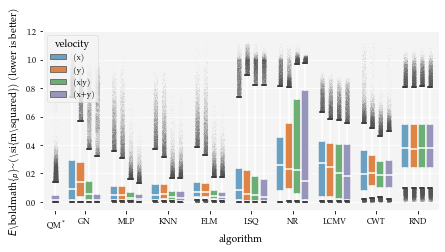

In [59]:
ax = sns.boxplot(
    data=sensors_boxplots_data.query('error_type == "location"'),
    x='method', y='error_value', hue='input_mode_bracket', 
    whis=[5, 95],
    order=['QM$^*$'] + sensor_row_order,
    hue_order=['(x)', '(y)', '(x|y)', '(x+y)'], 
    palette=palette,
    fliersize=0.1,
    boxprops={'edgecolor': adjust_lightness('#E5E5E5', 1.065)},
    medianprops={'color': 'white'},
    whiskerprops={'color': 'white'},
    capprops={'color': 'black'},
    flierprops={'alpha': 0.1}
)

lines = ax.get_lines()
outlier_idx = [l.get_markersize() == 0.1 for l in lines]
outliers = [l for l, i in zip(lines, outlier_idx) if i]
for outlier in outliers:
    yoffsets = outlier.get_xdata()
    outlier.set_xdata(yoffsets + np.random.uniform(-0.05, 0.05, yoffsets.size))

plt.ylim([-0.06, 1.2])
plt.legend(loc='upper left', title='velocity')
plt.ylabel(r'$E$\boldmath{$_p$}~(\si{m\squared}) (lower is better)')
plt.gcf().subplots_adjust(
    left=0.095,
    right=0.99,
    top=0.98,
    bottom=0.15
)
xticklabels = ax.get_xticklabels();
xticklabels[0] = mpl.text.Text(0.3, 0, 'QM$^*$');
ticks = ax.get_xticks().astype('float')
ticks[0] = 0.3
ax.set_xticks(ticks)
ax.set_xticklabels(xticklabels);
ax.set_xlabel('algorithm')
plt.xlim([0, plt.xlim()[1]])
plt.gcf().set_figheight(3)
plt.gcf().savefig('images/publication/sensors_boxplots_location')
# subprocess.run('convert -quality 00 -density 300x300 images/publication/sensors_boxplots_location.pdf images/publication/sensors_boxplots_location.png')
# subprocess.run(["rm", 'images/publication/sensors_boxplots_location.pdf'])
plt.show()

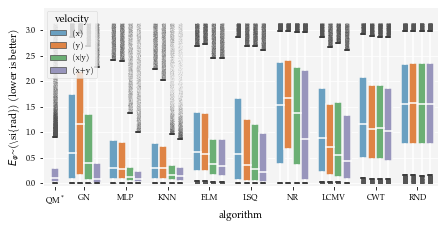

In [60]:
ax = sns.boxplot(
    data=sensors_boxplots_data.query('error_type == "orientation"'),
    x='method', y='error_value', hue='input_mode_bracket', 
    whis=[5, 95],
    order=['QM$^*$'] + sensor_row_order,
    hue_order=['(x)', '(y)', '(x|y)', '(x+y)'], 
    palette=palette,
    fliersize=0.1,
    boxprops={'edgecolor': adjust_lightness('#E5E5E5', 1.065)},
    medianprops={'color': 'white'},
    whiskerprops={'color': 'white'},
    capprops={'color': 'black'},
    flierprops={'alpha': 0.1}
)

lines = ax.get_lines()
outlier_idx = [l.get_markersize() == 0.1 for l in lines]
outliers = [l for l, i in zip(lines, outlier_idx) if i]
for outlier in outliers:
    yoffsets = outlier.get_xdata()
    outlier.set_xdata(yoffsets + np.random.uniform(-0.05, 0.05, yoffsets.size))

plt.ylim([-0.06, 1.1*np.pi])
plt.legend(loc='upper left', title='velocity')
plt.ylabel(r'$E_\varphi$~(\si{rad}) (lower is better)')
plt.gcf().subplots_adjust(
    left=0.095,
    right=0.99,
    top=0.98,
    bottom=0.15
)
xticklabels = ax.get_xticklabels();
xticklabels[0] = mpl.text.Text(0.3, 0, 'QM$^*$');
ticks = ax.get_xticks().astype('float')
ticks[0] = 0.3
ax.set_xticks(ticks)
ax.set_xticklabels(xticklabels);
ax.set_xlabel('algorithm')
plt.xlim([0, plt.xlim()[1]])
plt.gcf().set_figheight(3)
plt.gcf().savefig('images/publication/sensors_boxplots_orientation')
# subprocess.run('convert -quality 00 -density 300x300 images/publication/sensors_boxplots_orientation.pdf images/publication/sensors_boxplots_orientation.png')
# subprocess.run(["rm", 'images/publication/sensors_boxplots_orientation.pdf'])
plt.show()

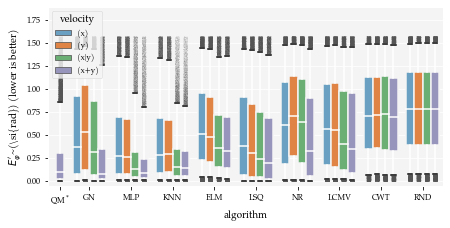

In [61]:
ax = sns.boxplot(
    data=sensors_boxplots_data.query('error_type == "orientation_no_phase"'),
    x='method', y='error_value', hue='input_mode_bracket', 
    whis=[5, 95],
    order=['QM$^*$'] + sensor_row_order,
    hue_order=['(x)', '(y)', '(x|y)', '(x+y)'], 
    palette=palette,
    fliersize=0.1,
    boxprops={'edgecolor': adjust_lightness('#E5E5E5', 1.065)},
    medianprops={'color': 'white'},
    whiskerprops={'color': 'white'},
    capprops={'color': 'black'},
    flierprops={'alpha': 0.1}
)

lines = ax.get_lines()
outlier_idx = [l.get_markersize() == 0.1 for l in lines]
outliers = [l for l, i in zip(lines, outlier_idx) if i]
for outlier in outliers:
    yoffsets = outlier.get_xdata()
    outlier.set_xdata(yoffsets + np.random.uniform(-0.05, 0.05, yoffsets.size))

plt.ylim([-0.06, 0.6*np.pi])
plt.legend(loc='upper left', title='velocity')
plt.ylabel(r"$E_\varphi'$~(\si{rad}) (lower is better)")
plt.gcf().subplots_adjust(
    left=0.095,
    right=0.99,
    top=0.98,
    bottom=0.15
)
xticklabels = ax.get_xticklabels();
xticklabels[0] = mpl.text.Text(0.3, 0, 'QM$^*$');
ticks = ax.get_xticks().astype('float')
ticks[0] = 0.3
ax.set_xticks(ticks)
ax.set_xticklabels(xticklabels);
ax.set_xlabel('algorithm')
plt.xlim([0, plt.xlim()[1]])
plt.gcf().set_figheight(3)
plt.gcf().savefig('images/publication/sensors_boxplots_orientation_no_phase')
# subprocess.run('convert -quality 00 -density 300x300 images/publication/sensors_boxplots_orientation_no_phase.pdf images/publication/sensors_boxplots_orientation_no_phase.png')
# subprocess.run(["rm", 'images/publication/sensors_boxplots_orientation_no_phase.pdf'])
plt.show()

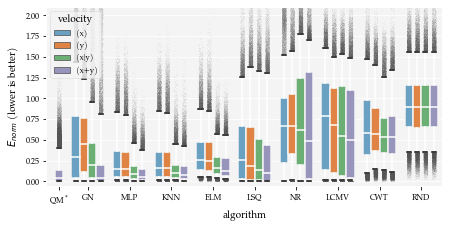

In [62]:
ax = sns.boxplot(
    data=sensors_boxplots_data.query('error_type == "prediction"'),
    x='method', y='error_value', hue='input_mode_bracket', 
    whis=[5, 95],
    order=['QM$^*$'] + sensor_row_order,
    hue_order=['(x)', '(y)', '(x|y)', '(x+y)'], 
    palette=palette,
    fliersize=0.1,
    boxprops={'edgecolor': adjust_lightness('#E5E5E5', 1.065)},
    medianprops={'color': 'white'},
    whiskerprops={'color': 'white'},
    capprops={'color': 'black'},
    flierprops={'alpha': 0.1}
)

lines = ax.get_lines()
outlier_idx = [l.get_markersize() == 0.1 for l in lines]
outliers = [l for l, i in zip(lines, outlier_idx) if i]
for outlier in outliers:
    yoffsets = outlier.get_xdata()
    outlier.set_xdata(yoffsets + np.random.uniform(-0.05, 0.05, yoffsets.size))

plt.ylim([-0.06, 2.1])
plt.legend(loc='upper left', title='velocity')
plt.ylabel(r"$E_{norm}$ (lower is better)")
plt.gcf().subplots_adjust(
    left=0.095,
    right=0.99,
    top=0.98,
    bottom=0.15
)
xticklabels = ax.get_xticklabels();
xticklabels[0] = mpl.text.Text(0.3, 0, 'QM$^*$');
ticks = ax.get_xticks().astype('float')
ticks[0] = 0.3
ax.set_xticks(ticks)
ax.set_xticklabels(xticklabels);
ax.set_xlabel('algorithm')
plt.xlim([0, plt.xlim()[1]])
plt.gcf().set_figheight(3)
plt.gcf().savefig('images/publication/sensors_boxplots_prediction')
# subprocess.run('convert -quality 00 -density 300x300 images/publication/sensors_boxplots_prediction.pdf images/publication/sensors_boxplots_prediction.png')
# subprocess.run(["rm", 'images/publication/sensors_boxplots_prediction.pdf'])
plt.show()

#### Histograms

In [ ]:
# # Update styles
# old_face_color = mpl.rcParams['axes.facecolor']
# mpl.rcParams['axes.facecolor'] = (0, 0, 0, 0)
# mpl.rcParams['axes.grid'] = False

# # Helpers
# def plot_histogram(data, **kwargs):
#     bins = np.linspace(0, 1.5, 250)
#     color = kwargs.pop('color')
#     plt.hist(data, bins=bins, label=kwargs.pop('label'), alpha=0.5, edgecolor=color, color=color)
    
# def label(data, color, label):
#     ax=plt.gca()
#     ax.text(-0.015, 0.2, label, fontsize=8, ha='right', va='center', transform=ax.transAxes)
    
# # Make overlapping histograms
# g = sns.FacetGrid(combined_data, row='method', hue='method', aspect=6/0.3708, height=0.3708, palette=create_my_palette(),
#                   row_order=['GN', 'LSQ', 'QM', 'NR', 'KNN', 'MLP', 'ELM', 'LCMV', 'CWT', 'RND'],
#                   hue_order=['GN', 'LSQ', 'QM', 'NR', 'KNN', 'MLP', 'ELM', 'LCMV', 'CWT', 'RND'])
# g.map(plot_histogram, 'prediction_error')
# g.map(label, 'prediction_error')
# g.set_axis_labels("prediction error", "")
# g.set_titles('')
# g.set(yticks=[], xlim=[0, 1.2])
# g.despine(bottom=True, left=True)
# g.fig.subplots_adjust(hspace=-0.55, left=0.08, bottom=0.15)
# g.fig.savefig('images/publication/histograms')
# for ax in g.axes.flat[0:-1]:
#     ax.tick_params(axis='x', length=0)

# # Reset style
# mpl.rcParams['axes.facecolor'] = old_face_color
# mpl.rcParams['axes.grid'] = True

In [ ]:
def plot_method_histogram(data, m1, m2):
    if data.error_type.nunique() > 1:
        raise ValueError('Plot one eror type at a time!')
    if data.error_type.iloc[0] == 'location':
        bins = np.linspace(0, 1, 80)
        label = r'$E$\boldmath{$_p$} (\si{m\squared})'
        top=0.88
        right=0.99
        bottom=0.31
        left=0.15
        labelpad=-3
    elif data.error_type.iloc[0] == 'orientation':
        bins = np.linspace(0, np.pi, 80)
        label = r'$E_\varphi$ (\si{rad})'
        top=0.88
        right=0.99
        bottom=0.31
        left=0.15
        labelpad=-2.5
    elif data.error_type.iloc[0] == 'orientation_no_phase':
        bins = np.linspace(0, np.pi/2, 80)
        label = r"$E_\varphi'$ (\si{rad})"
        top=0.88
        right=0.99
        bottom=0.31
        left=0.15
        labelpad=-2.5
    else:
        bins = np.linspace(0, 1, 80)
        label = r'$E_{norm}'
        top=0.88
        right=0.99
        bottom=0.31
        left=0.15
        labelpad=-2
    blue='#0093DD'
    red='#F20010'
    
    fig = plt.figure(figsize=figure_dimensions(0.33))
    plt.hist(data[data.method == m1].error_value, bins=bins, color=blue, label=m1, edgecolor='black', alpha=0.5)
    plt.hist(data[data.method == m2].error_value, bins=bins, color=red, label=m2, edgecolor='black', alpha=0.5)
    plt.xlabel(label, labelpad=labelpad)
    plt.ylabel('count')
    plt.gca().ticklabel_format(axis='y', style='sci')
    plt.gca().get_yaxis().get_major_formatter().set_powerlimits((0, 0))
    plt.legend()
    plt.gcf().subplots_adjust(top=top, right=right, bottom=bottom, left=left)

In [ ]:
# u_methods = combined_data.method.unique()
# for etype in combined_data.error_type.unique():
#     for row_idx, row_mtd in enumerate(u_methods[:-1]):
#         for col_idx, col_mtd in enumerate(u_methods[row_idx+1:]):
#             plot_method_histogram(combined_data.query('error_type == "' + etype +'"'), row_mtd, col_mtd)
#             plt.gcf().savefig('images/publication/combined_histogram_' + etype +'_' + row_mtd + '_' + col_mtd)
#             plt.close()

#### Bars with split

In [ ]:
def groupedStackedSplitBars(data, group, bar, stack, value_1, value_2, colors, 
                            group_order=None, bar_order=None, stack_order=None,
                            group_labels=None, bar_labels=None, stack_labels=None,
                            stack_title=None, edge_color='white',
                            group_width_factor=0.8, bar_width_factor=0.8,
                            split_width_factor=1, group_label_offset=-30,
                            bar_label_rotation=0):
    """Plots groups of stacked bars.
    
    Parameters
    ----------
    data: Pandas dataframe
        
    group: string,
        Name of column to use as group
    bar: string,
        Name of the column to use as bar in each group
    stack: string,
        Name of the column to use as stack in each bar
    value_1 & value_2: string,
        Name of the column to use as value for each stack
    colors: data frame
        A data frame containing the colors to use for each stack in each split.
    group_width_factor: float
        Factor of group width. When 1, groups are touching.
    bar_width_factor: float
        Factor of bar width. When 1, bars are touching
    split_width_factor: float
        Factor of split width. When 1, splits are touching
    group_label_offset: float
        y-locations offset of group labels in points. Depends on font size and padding.
    bar_label_rotation: float
        Rotation of the bar labels.
    """
    
    # Fill in None values
    if group_order is None:
        group_order = data[group].unique()
    if bar_order is None:
        bar_order = data[bar].unique()
    if stack_order is None:
        stack_order = data[stack].unique()
    if bar_labels is None:
        bar_labels = bar_order
    if group_labels is None:
        group_labels = group_order
    if stack_labels is None:
        stack_labels = stack_order
    if stack_title is None:
        stack_title = stack
    
    # Compute bar and group positions
    num_groups = len(group_order)
    num_bars = len(bar_order)
    num_stacks = len(stack_order)
    bar_width = group_width_factor / num_bars
    group_offset = np.arange(num_groups) + 1
    bar_positions = np.array([group_offset + bar_idx * bar_width for bar_idx in range(num_bars)])
    # 3D: 1-bar, 2-split, 3-group
    split_positions = np.array([[bar_pos -  bar_width_factor * bar_width/4, bar_pos + bar_width_factor * bar_width/4] for bar_pos in bar_positions])
    group_centers = np.array([group_offset[group_idx] + (num_bars - 1) / 2  * bar_width 
                              for group_idx in range(num_groups)])
    
    # Plot the stacks in the given order
    for group_idx in range(num_groups):
        group_data = data[data[group] == group_order[group_idx]]
        
        split_idx = 0
        for bar_idx in range(num_bars):
            bar_data = group_data[group_data[bar] == bar_order[bar_idx]]
            
            value_so_far = 0
            for stack_idx in range(num_stacks):
                stack_data = bar_data[bar_data[stack] == stack_order[stack_idx]]
                plt.bar(split_positions[bar_idx][0][group_idx], 
                        stack_data[value_1],
                        bottom=value_so_far,
                        width=bar_width_factor * split_width_factor * bar_width/2,
                        edgecolor=edge_color,
                        color=colors[0][stack_idx % len(colors[0])])
                value_so_far = value_so_far + stack_data[value_1].tolist()[0]                
            split_idx = split_idx + 1
            
            value_so_far = 0
            for stack_idx in range(num_stacks):
                stack_data = bar_data[bar_data[stack] == stack_order[stack_idx]]
                plt.bar(split_positions[bar_idx][1][group_idx], 
                        stack_data[value_2],
                        bottom=value_so_far,
                        width=bar_width_factor *split_width_factor * bar_width/2,
                        edgecolor=edge_color,
                        color=colors[1][stack_idx % len(colors[1])])
                value_so_far = value_so_far + stack_data[value_2].tolist()[0]                
            split_idx = split_idx + 1
            
        # Add group labels
        ax=plt.gca()
        plt.annotate(group_labels[group_idx], 
                     xy=(group_centers[group_idx], 0),
                     xycoords=ax.get_xaxis_transform(),
                     xytext=(0, group_label_offset),
                     textcoords='offset points',
                     ha="center", va="center",
                     fontsize=mpl.rcParams['xtick.labelsize'])        
        
    # Add ticks, labels, legend...
    plt.xticks(bar_positions.flatten(), np.repeat(bar_labels, num_groups, axis=0), rotation=bar_label_rotation)
    plt.legend(stack_labels, title=stack_title)

In [ ]:
# levels = [0.01, 0.03, 0.05, 0.09]
# ori_levels = [x*np.pi for x in levels]

# loc_colors = contourColors([0] + levels, 'Blues_r')
# ori_colors = contourColors([0] + levels, 'Oranges_r')
# colors = [loc_colors.tolist(), ori_colors.tolist()]

# loc_areas = aggregate_area_data(resolution_data, 'resolution', 'location_error', levels + [np.Inf])
# ori_areas = aggregate_area_data(resolution_data, 'resolution', 'orientation_error', stack_levels + [np.Inf])
# ori_areas.threshold = ori_areas.threshold / np.pi
# areas = pd.merge(loc_areas, ori_areas, on=['method', 'resolution', 'threshold'], suffixes=('_loc', '_ori'))

# legend_labels = list(reversed(["{:d}".format(int(x)) + '~\si{cm}' for x in np.flip(levels)*100])) + \
#                 list(reversed(["{:.2f}".format(x) + '\(\pi\)~\si{rad}' for x in np.flip(levels)]));

# groupedStackedSplitBars(areas, 'method', 'resolution', 'threshold', 'area_loc', 'area_ori', colors,
#                         stack_order=levels,
#                         bar_order=np.flip(levels),
#                         bar_labels=["{:d}".format(int(x)) for x in np.flip(levels)*100],
#                         stack_labels=legend_labels,
#                         group_order=['GN', 'QM', 'NR', 'KNN', 'ELM', 'LCMV', 'CWT'],
#                         bar_label_rotation=0,
#                         group_label_offset=-20,
#                         stack_title=r'threshold')
# plt.ylabel(r'area (\si{cm**2})')
# plt.xlabel(r'method / resolution (\(\times 0.01\))', labelpad=12)
# plt.ylim([0, 0.53])
# plt.grid(axis='x')
# plt.gcf().subplots_adjust(bottom=0.14) # Keeps xlabel on the compiled figure
# plt.gcf().savefig('images/publication/resolution_area_bars')
# plt.show()

In [ ]:
# levels = [0.01, 0.03, 0.05, 0.09]
# ori_levels = [x*np.pi for x in levels]

# loc_colors = contourColors([0] + levels, 'Blues_r')
# ori_colors = contourColors([0] + levels, 'Oranges_r')
# colors = [loc_colors.tolist(), ori_colors.tolist()]

# loc_areas = aggregate_area_data(sensor_data, 'input_mode', 'location_error', levels + [np.Inf])
# ori_areas = aggregate_area_data(sensor_data, 'input_mode', 'orientation_error', stack_levels + [np.Inf])
# ori_areas.threshold = ori_areas.threshold / np.pi
# areas = pd.merge(loc_areas, ori_areas, on=['method', 'input_mode', 'threshold'], suffixes=('_loc', '_ori'))

# legend_labels = list(reversed(["{:d}".format(int(x)) + '~\si{cm}' for x in np.flip(levels)*100])) + \
#                 list(reversed(["{:.2f}".format(x) + '\(\pi\)~\si{rad}' for x in np.flip(levels)]));

# groupedStackedSplitBars(areas, 'method', 'input_mode', 'threshold', 'area_loc', 'area_ori', colors,
#                         stack_order=levels,
#                         bar_order=['x', 'y', 'x|y', 'x+y'],
#                         stack_labels=legend_labels,
#                         group_order=['GN', 'LSQ', 'NR', 'KNN', 'MLP', 'ELM', 'LCMV', 'CWT'],
#                         bar_label_rotation=90,
#                         group_label_offset=-28,
#                         stack_title=r'threshold')
# plt.ylabel(r'area (\si{cm**2})')
# plt.xlabel(r'method / resolution (\(\times 0.01\))', labelpad=12)
# plt.ylim([0, 0.53])
# plt.grid(axis='x')
# plt.gcf().subplots_adjust(bottom=0.16) # Keeps xlabel on the compiled figure
# plt.gcf().savefig('images/publication/sensors_area_bars')
# plt.show()